# Plasticity From new Frac

Von Mises elasto-plasticity based upon new new frac model:

Find more information here: 
https://newfrac.github.io/fenicsx-fracture/notebooks/plasticity/plasticity.html

Updated for Fenics 0.8.0
Not using SNES Solver instead using NewtonSolver from Dolfinx


In [1]:
import numpy as np

import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log, default_scalar_type
from dolfinx.fem import Constant, dirichletbc, Function, functionspace, Expression

from dolfinx.fem.petsc import NonlinearProblem, LinearProblem
from dolfinx.nls.petsc import NewtonSolver
import ufl
from ufl import (
    TestFunctions,
    TrialFunction,
    Identity,
    grad,
    det,
    div,
    dev,
    inv,
    tr,
    sqrt,
    conditional,
    gt,
    dx,
    inner,
    derivative,
    dot,
    ln,
    split,
    TestFunction,
    indices,
    as_tensor,
    as_vector
)

from basix.ufl import element, mixed_element, quadrature_element
from datetime import datetime
from dolfinx.plot import vtk_mesh
from dolfinx.io import VTXWriter, gmshio

import gmsh
import pyvista

pyvista.set_jupyter_backend("client")
## Define temporal parameters

# Meshing

In [2]:
# Geometric parameters
geom = {"Re" : 1.3,     # m
        "Ri" : 1.,      # m
        "lc" : 0.03,    # size of a cell
        }


# Mechanicals parameters
mech = {"E" : 1.,    # MPa
        "nu" : 0.3,     #       
        "sig0" : 250. / 70.e3,  # MPa
        "H" : 1. / 99., # MPa
        }


# Study parameters
stud = {"deg u" : 2,    # Interpolation of u
        "deg sig" : 2,  # Interpolation of sig, eps, p
        "N incr" : 50,  # Number of load steps
        }

In [3]:
R_e, R_i = geom["Re"], geom["Ri"]  # external/internal radius

# mesh parameters
lc = 0.03 
gdim = 2
verbosity = 10

# mesh using gmsh
mesh_comm = MPI.COMM_WORLD
model_rank = 0
gmsh.initialize()
facet_tags = {"Lx": 1, "Ly":2, "inner": 3, "outer": 4}
cell_tags = {"all": 20}
if mesh_comm.rank == model_rank:
    model = gmsh.model()
    model.add("Quart_cylinder")
    model.setCurrent("Quart_cylinder")
    # Create the points
    pix = model.occ.addPoint(R_i, 0.0, 0, lc)
    pex = model.occ.addPoint(R_e, 0, 0, lc)
    piy = model.occ.addPoint(0., R_i, 0, lc)
    pey = model.occ.addPoint(0., R_e, 0, lc)
    center = model.occ.addPoint(0., 0., 0, lc)
    # Create the lines
    lx = model.occ.addLine(pix, pex, tag = facet_tags["Lx"])
    lout = model.occ.addCircleArc(pex, center, pey, tag = facet_tags["outer"])
    ly = model.occ.addLine(pey, piy, tag = facet_tags["Ly"])
    lin = model.occ.addCircleArc(piy, center, pix, tag = facet_tags["inner"])
    # Create the surface
    cloop1 = model.occ.addCurveLoop([lx, lout, ly, lin])
    surface_1 = model.occ.addPlaneSurface([cloop1], tag = cell_tags["all"])
    model.occ.synchronize()      
    # Assign mesh and facet tags
    surface_entities = [entity[1] for entity in model.getEntities(2)]
    model.addPhysicalGroup(2, surface_entities, tag=cell_tags["all"])    
    model.setPhysicalName(2, 2, "Quart_cylinder surface")
    for (key, value) in facet_tags.items():
            model.addPhysicalGroup(1, [value], tag=value) # 1 : it is the dimension of the object (here a curve)
            model.setPhysicalName(1, value, key)
    # Finalize mesh
    model.occ.synchronize()              
    gmsh.option.setNumber('General.Verbosity', verbosity)
    model.mesh.generate(gdim)
    if mesh_comm == model_rank:
        my_model = model
    else :
        my_model = None

# import the mesh in fenicsx with gmshio
msh, cell_tags, facet_tags = gmshio.model_to_mesh(
            model, mesh_comm, 0., gdim=2
        )

msh.topology.create_connectivity(msh.topology.dim - 1, msh.topology.dim)
msh.name = "Quart_cylinder"
cell_tags.name = f"{msh.name}_cells"
facet_tags.name = f"{msh.name}_facets"

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Circle)
Info    : [ 80%] Meshing curve 4 (Circle)
Info    : Done meshing 1D (Wall 0.000198042s, CPU 0.00033s)
Info    : Meshing 2D...
Info    : Meshing surface 20 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0262688s, CPU 0.026565s)
Info    : 809 nodes 1619 elements


In [4]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(msh, msh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:34211/index.html?ui=P_0xffff58fbc580_0&reconnect=auto' style='widt…

In [5]:
E = Constant(msh, mech["E"])
nu = Constant(msh, mech["nu"])
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
mu = E / 2.0 / (1 + nu)
sig0 = Constant(msh, mech["sig0"])  # yield strength
H = Constant(msh,mech["H"])  # hardening modulus


# Function Spaces

In [6]:
deg_u = stud["deg u"]
deg_stress = stud["deg sig"]
Ve = element(
    "Lagrange", msh.basix_cell(), deg_u, shape=(2,)
)  # 2 degreeso of freedom
V = functionspace(msh, Ve)

We = quadrature_element(msh.basix_cell(), value_shape=(4,), degree=deg_stress)
W = functionspace(msh, We)

W_scal_e = quadrature_element(msh.basix_cell(), degree=deg_stress)
W_scal = functionspace(msh, W_scal_e)

In [7]:
sig = Function(W,name = "Stress")
sig_old = Function(W,name = "Stress_old")
#n_elas = Function(W)
#beta = Function(W_scal)
p = Function(W_scal, name="Cumulative_plastic_strain")
u = Function(V, name="Total_displacement")
du = Function(V, name="Iteration_Correction")
#Du = Function(V, name="Current_increment")

v = TrialFunction(V)
u_ = TestFunction(V)


dx = ufl.Measure("dx",domain=msh,  metadata={"quadrature_degree": deg_u, "quadrature_scheme": "default"} )
dx_m = ufl.Measure("dx",domain=msh,  metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"} )
ds = ufl.Measure("ds", domain=msh, subdomain_data=facet_tags)
ds_m = ufl.Measure("ds", domain=msh, subdomain_data=facet_tags,  metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"})

n = ufl.FacetNormal(msh)

# Boundary Conditions

In [8]:
bottom_facets = facet_tags.find(1)
left_facets = facet_tags.find(2)
fdim = msh.topology.dim - 1

bottom_dofs_y = fem.locate_dofs_topological(V.sub(1), fdim, bottom_facets)
left_dofs_x = fem.locate_dofs_topological(V.sub(0),fdim, left_facets)

sym_bottom = fem.dirichletbc(0.0, bottom_dofs_y, V.sub(1))
sym_left = fem.dirichletbc(0.0, left_dofs_x, V.sub(0))

bcs = [sym_bottom, sym_left]

q_lim = float(2. / np.sqrt(3) * np.log(R_e / R_i) * mech["sig0"])
loading = fem.Constant(msh, 0. * q_lim)

def F_ext(v):
    return -loading * ufl.inner(n, v) * ds_m(3) # force is applied at the inner boundary 3

# Constitutive Relations 

In [9]:
from ufl.tensors import ComponentTensor


def eps(v: Function) -> ComponentTensor:
    """
    Generates a plain strain tensor from input of a 2D displacement vector.


    Parameters:
    -----------
        u (2d Vector Funciton): 2D displacement vector.

    Returns:
    --------
        3x3 Tensor: Plain strain tensor generated from the displacement vector.
    """
    e = ufl.sym(grad(v))
    return as_tensor([[e[0, 0], e[0, 1], 0], [e[0, 1], e[1, 1], 0], [0, 0, 0]])



def sigma_tr(eps_el):
    """
    Generates the stress tensor from the input of a plain strain tensor.

    Parameters:
    ----------
        eps_el (numpy.ndarray): Plain strain tensor.

    Returns:
    --------
        3x3 Tensor: the trace of the plain stress tensor
    """
    return 1./3. * (3. * lmbda + 2. * mu) * ufl.tr(eps_el) * ufl.Identity(3)


def sigma_dev(eps_el):
    """
    Generates the stress tensor from the input of a plain strain tensor.

    Parameters:
    ----------
        eps_el (numpy.ndarray): Plain strain tensor.

    Returns:
    --------
        3x3 Tensor: The deviatoric part of the stress tensor.
    """
    return 2. * mu * ufl.dev(eps_el)


def as_3D_tensor(X):
    """Converts an array to a 3D tensor.

    Parameters:
    ----------
       X (Function): Array to be converted to 3D tensor.

    Returns:
    --------
        3x3 Tensor: 3D tensor generated from the input array.
    """
    return ufl.as_tensor([[X[0], X[3], 0],
                      [X[3], X[1], 0],
                      [0, 0, X[2]]])

def tensor_to_vector(X): 
    ''' 
    Take a 3x3 tensor and return a vector of size 4 in 2D
    '''
    return ufl.as_vector([X[0, 0], X[1, 1], X[2, 2], X[0, 1]])


def sigma(eps_el: Function) -> ComponentTensor:
    
    return lmbda * tr(eps_el) * Identity(3) + 2 * mu * eps_el


In [10]:
def normVM(sig): # Von Mises equivalent stress
    s_ = ufl.dev(sig)
    return ufl.sqrt(3 / 2. * ufl.inner(s_, s_))


def compute_new_state(du, sig_old, p_old) : 
    '''
    This function return the actualised mechanical state for a given displacement increment
    We separate spheric and deviatoric parts of the stress to optimize convergence of the solver
    '''
    sig_n = as_3D_tensor(sig_old) #stress as a tensor
    sig_el_tr = 1./3 * ufl.tr(sig_n) * ufl.Identity(3) + sigma_tr(eps(du)) #New stress assuming elastic (Trace)
    sig_el_dev = ufl.dev(sig_n) + sigma_dev(eps(du)) #New stress assumign elastic Deviatoric
    sig_el = sig_el_tr + sig_el_dev #toatl stress (trace + dev)
    
    criterion = normVM(sig_el) - sig0 - H * p_old #Check if we have plasticly deformed

    dp_ = ufl.conditional(criterion < 0., 0., criterion / (3. * mu + H)) #Conditional if we did deform or not.
    direction = ufl.dev(sig_n)/normVM(sig_n) #Direction of the plastic flow
    new_sig_tr = sig_el_tr #New stress assuming elastic (Trace)
    new_sig_dev = ufl.conditional(criterion < 0., sig_el_dev, sig_el_dev - 2. * mu * 3./2. * dp_ * direction)  #New stress accouting for plasticity (Deviatoric)

    return new_sig_tr, new_sig_dev, dp_

In [11]:
new_sig_tr, new_sig_dev, dp_ = compute_new_state(du, sig, p)

residual_u = ufl.inner(new_sig_tr, eps(v)) * dx_m + ufl.inner(new_sig_dev, eps(v)) * dx - F_ext(v) 


J_u = ufl.derivative(residual_u, du, u_)

In [12]:
problemName = "2D Plasticity Test"

U = functionspace(msh, ("Lagrange", 2))

mises = Function(U,name = "mises")

In [13]:
pointForStress = [geom["Ri"],0,0]

bb_tree = dolfinx.geometry.bb_tree(msh,msh.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, np.array(pointForStress))
colliding_cells = dolfinx.geometry.compute_colliding_cells(msh, cell_candidates,  np.array(pointForStress))


In [14]:
Nincr = stud["N incr"]

load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))



problem = NonlinearProblem(residual_u, du, bcs, J_u)


solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
#opts[f"{option_prefix}pc_hypre_type"] = "boomeramg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

new_sig_tr, new_sig_dev, dp_= compute_new_state(du, sig, p)


for (i, t) in enumerate(load_steps):
    loading.value = t * q_lim
    du.x.array[:] = 0.
    print(f"\n----------- Solve for t={t:5.3f} -----------")
    (iter, converged) = solver.solve(du)
    print("Number of iterations : ", iter)
    print(f"Converged reason = {converged:1.3f}")
    
    sig_exp = Expression(tensor_to_vector(new_sig_dev + new_sig_tr),W.element.interpolation_points())
    sig.interpolate(sig_exp)
    
    p_exp = Expression(p + dp_,W_scal.element.interpolation_points())
    p.interpolate(p_exp)
    
    
    
    u.vector.axpy(1, du.vector)
    u.x.scatter_forward()
    sig.x.scatter_forward()
    p.x.scatter_forward()
    
        # Post-processing
    u_pointe = u.eval(pointForStress,colliding_cells.array[0])[0]
    du_pointe = du.eval(pointForStress,colliding_cells.array[0])[0]
    results[i + 1, :] = (u_pointe, t)



----------- Solve for t=0.148 -----------
Number of iterations :  2
Converged reason = 1.000

----------- Solve for t=0.210 -----------
Number of iterations :  2
Converged reason = 1.000

----------- Solve for t=0.257 -----------
Number of iterations :  2
Converged reason = 1.000

----------- Solve for t=0.297 -----------
Number of iterations :  2
Converged reason = 1.000

----------- Solve for t=0.332 -----------
Number of iterations :  2
Converged reason = 1.000

----------- Solve for t=0.363 -----------
Number of iterations :  2
Converged reason = 1.000

----------- Solve for t=0.392 -----------
Number of iterations :  2
Converged reason = 1.000

----------- Solve for t=0.420 -----------
Number of iterations :  2
Converged reason = 1.000

----------- Solve for t=0.445 -----------
Number of iterations :  2
Converged reason = 1.000

----------- Solve for t=0.469 -----------
Number of iterations :  2
Converged reason = 1.000

----------- Solve for t=0.492 -----------
Number of iterati

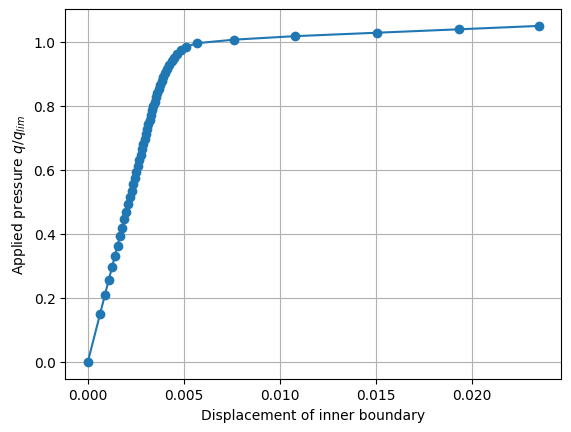

In [15]:
import matplotlib.pyplot as plt
plt.plot(results[:, 0], results[:, 1], "-o")
plt.xlabel("Displacement of inner boundary")
plt.ylabel(r"Applied pressure $q/q_{lim}$")
plt.grid()
plt.show()
